## Download from GitHub

In [24]:
!git clone https://github.com/jerryuhoo/Perceptual-Loss.git
%cd Perceptual-Loss

Cloning into 'Perceptual-Loss'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 102 (delta 53), reused 67 (delta 25), pack-reused 0
Receiving objects: 100% (102/102), 8.36 MiB | 13.81 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/Perceptual-Loss/Perceptual-Loss


## Display Audio

In [25]:
from IPython.display import Audio

Audio('test_wavs/v_gt.wav')

In [26]:
Audio('test_wavs/v_bad.wav')

In [27]:
Audio('test_wavs/v_good.wav')

## Load audio

In [28]:
import torchaudio
import torch
from psycho_acoustic_loss import (
    psycho_acoustic_loss,
    compute_STFT,
    mapping2bark,
    get_analysis_params,
    maskingThresholdBark,
    mappingfrombarkmat,
    mappingfrombark,
    amplitude_to_db,

)
import numpy as np
import matplotlib.pyplot as plt

In [29]:
def plot_spectrogram(spectrogram, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time Frames')
    plt.ylabel('Frequency Bins')
    plt.show()

In [30]:
# Load audio
fs = 44100
N = 1024
nfilts = 64
mT_dB_shift = 0
normalize=True
if normalize:
    ref_dB = 120

# we can modify nfilts, mT_dB_shift, ref_dB to test the best loss


waveform, sample_rate = torchaudio.load("test_wavs/v_gt.wav")
audio_gt = waveform[0]

waveform, sample_rate = torchaudio.load("test_wavs/v_good.wav")
audio_good = waveform[0]

waveform, sample_rate = torchaudio.load("test_wavs/v_bad.wav")
assert fs == sample_rate
audio_bad = waveform[0]

print(audio_gt.shape)
print(audio_good.shape)
print(audio_bad.shape)

# Compute STFT
ys_gt = compute_STFT(audio_gt, N=N, normalize=normalize).unsqueeze(0).unsqueeze(0)
ys_good = compute_STFT(audio_good, N=N, normalize=normalize).unsqueeze(0).unsqueeze(0)
ys_bad = compute_STFT(audio_bad, N=N, normalize=normalize).unsqueeze(0).unsqueeze(0)

print(ys_gt.shape)
print(ys_good.shape)
print(ys_bad.shape)

torch.Size([110250])
torch.Size([110250])
torch.Size([110250])
torch.Size([1, 1, 1025, 216])
torch.Size([1, 1, 1025, 216])
torch.Size([1, 1, 1025, 216])


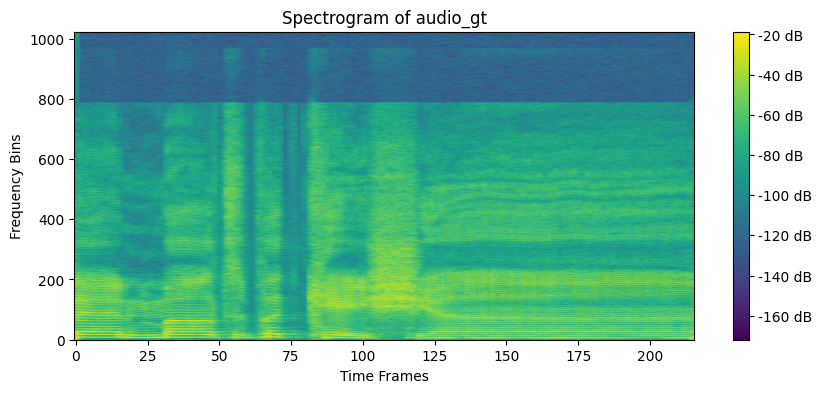

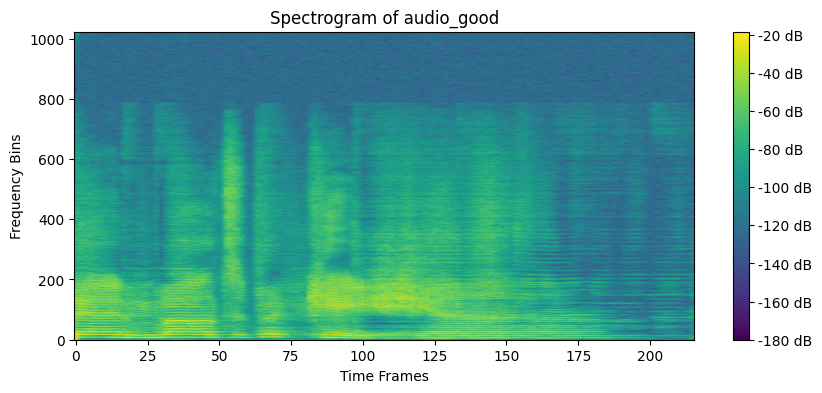

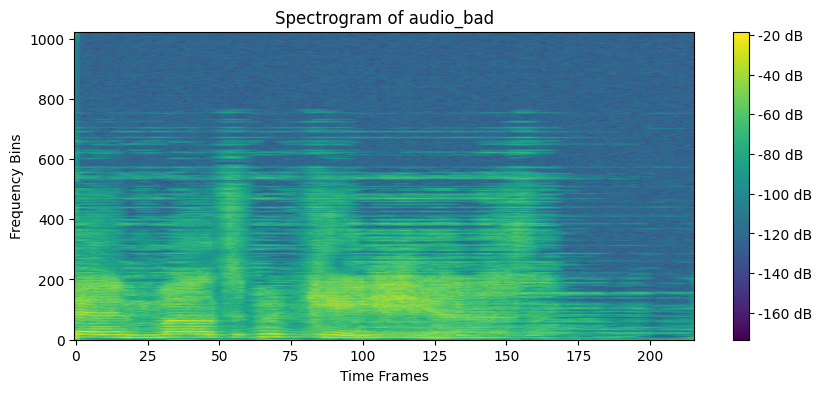

In [31]:
# Plot the spectrograms
# plot_spectrogram(20 * torch.log10(ys_gt + 1e-6), 'Spectrogram of audio_gt')
# plot_spectrogram(20 * torch.log10(ys_good + 1e-6), 'Spectrogram of audio_good')
# plot_spectrogram(20 * torch.log10(ys_bad + 1e-6), 'Spectrogram of audio_bad')
plot_spectrogram(amplitude_to_db(ys_gt), 'Spectrogram of audio_gt')
plot_spectrogram(amplitude_to_db(ys_good), 'Spectrogram of audio_good')
plot_spectrogram(amplitude_to_db(ys_bad), 'Spectrogram of audio_bad')


## Verify the loss

In [32]:
def plot_spectrum(spectrogram, frame_index, title, db_scale=True):
    plt.figure(figsize=(10, 4))
    spectrum = spectrogram[0, 0, :, frame_index]
    if db_scale:
        spectrum = amplitude_to_db(spectrum)
    plt.plot(np.linspace(0, spectrogram.shape[2] // 2, spectrogram.shape[2]), spectrum)
    plt.title(title)
    if db_scale:
        plt.ylabel('Amplitude (dB)')
    else:
        plt.ylabel('Amplitude')
    plt.xlabel('Frequency Bin')
    plt.show()

torch.Size([1, 1, 1025, 216])


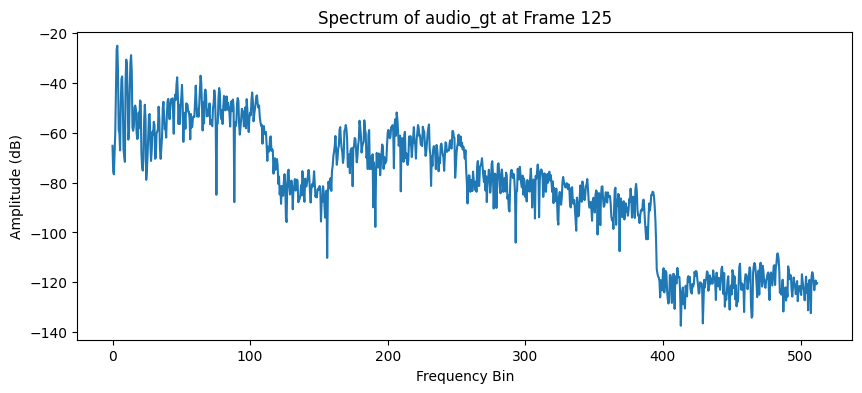

In [33]:
# take the 125th frame and plot the spectrum
frame_index = 125
print(ys_gt.shape)
plot_spectrum(ys_gt, frame_index, f'Spectrum of audio_gt at Frame {frame_index}')
# plot_spectrum(ys_good, frame_index, f'Spectrum of audio_good at Frame {frame_index}')
# plot_spectrum(ys_bad, frame_index, f'Spectrum of audio_bad at Frame {frame_index}')

In [34]:
def plot_bark_mt_bits(ys, use_LTQ=False, plot_bark=False, plot_mt=True, plot_bits=False):
    ys = ys.squeeze(0)
    N = ys.shape[1] - 1
    nfft = 2 * N
    print("N", N)
    print("nfft", nfft)

    W, spreadingfuncmatrix, alpha = get_analysis_params(fs, N, nfilts)
    W = W.to(ys.device)
    mXbark = mapping2bark(torch.abs(ys), W, 2 * N)

    example = amplitude_to_db(mXbark[0])
    # example = (mXbark[0])

    if plot_bark:
        plt.figure(figsize=(10, 6))
        plt.imshow(
            example.T,
            aspect="auto",
            origin="lower",
            extent=[0, example.shape[0], 0, example.shape[1]],
        )
        plt.colorbar(label="Amplitude (dB)")
        plt.xlabel("Time Frames")
        plt.ylabel("Bark Scale")
        plt.title("Spectrogram in Bark Scale")
        plt.show()

    mTbark = maskingThresholdBark(
    mXbark, spreadingfuncmatrix, alpha, fs, nfilts, use_LTQ=use_LTQ, ref_dB=ref_dB
)

    W_inv = mappingfrombarkmat(W, nfft)
    mT = mappingfrombark(mTbark, W_inv, nfft).transpose(-1, -2)
    mT_dB = amplitude_to_db(mT)
    mT_dB += mT_dB_shift
    ys_dB = amplitude_to_db(ys)
    smr_dB = ys_dB - mT_dB
    max_ys = torch.full_like(ys, 1)
    max_dB = amplitude_to_db(max_ys)
    noise_dB = ys_dB - smr_dB
    smax_to_mask_ratio_dB = max_dB - noise_dB
    assert torch.allclose(noise_dB, mT_dB, atol=1e-5)

    # get the 125th frame
    frame_index = 125
    ys_frame = ys_dB[0, :, frame_index]
    mT_frame = mT_dB[0, :, frame_index]
    smr_frame = smr_dB[0, :, frame_index]
    smax_to_mask_ratio_frame = smax_to_mask_ratio_dB[0, :, frame_index]

    # plot the spectrum and masking threshold for the 100th frame
    if plot_mt:
        plt.figure(figsize=(10, 6))
        freqs = np.linspace(0, 1024, 1025)  # 1025 frequency bins
        plt.plot(freqs, ys_frame, label="Spectrum")
        plt.plot(freqs, mT_frame, label="Masking Threshold", linestyle="--")
        plt.plot(freqs, smr_frame, label="SMR", linestyle="dotted")
        plt.plot(
            freqs, smax_to_mask_ratio_frame, label="Smax to Mask Ratio", linestyle="--"
        )
        plt.xlabel("Frequency Bins")
        plt.ylabel("Amplitude")
        plt.title(
            f"Spectrum and Masking Threshold at Frame={frame_index}, mT_dB_shift={mT_dB_shift} dB"
        )
        plt.legend()
        plt.show()

    quantization_bits = smax_to_mask_ratio_dB // 6
    # quantization_bits = torch.fill_(quantization_bits, 5)

    # plot quantization bits
    if plot_bits:
        plt.figure(figsize=(10, 6))
        plt.imshow(
            quantization_bits.squeeze().cpu().numpy(),
            aspect="auto",
            origin="lower",
            extent=[
                0,
                quantization_bits.squeeze().shape[1],
                0,
                quantization_bits.squeeze().shape[0],
            ],
        )
        plt.colorbar(label="Quantization Bits")
        plt.xlabel("Time Frames")
        plt.ylabel("Frequency Bins")
        plt.title("Quantization Bits")
        plt.show()
    return mT_frame, ys_frame

N 1024
nfft 2048


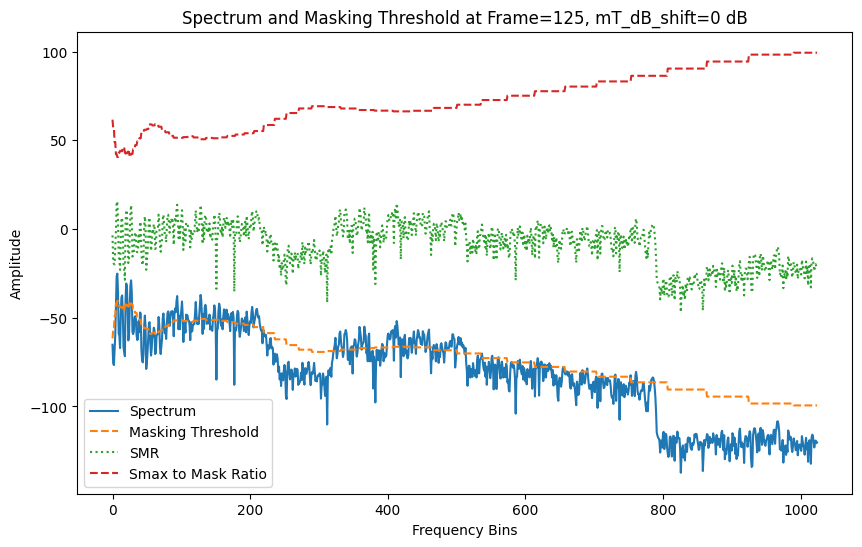

In [35]:
mT_frame_gt, ys_frame_gt = plot_bark_mt_bits(ys_gt)

N 1024
nfft 2048


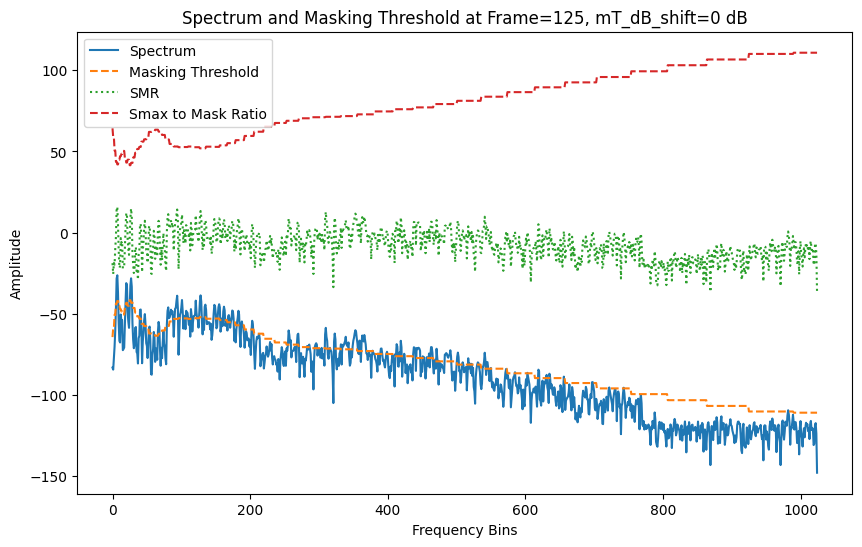

In [36]:
mT_frame_good, ys_frame_good = plot_bark_mt_bits(ys_good)

N 1024
nfft 2048


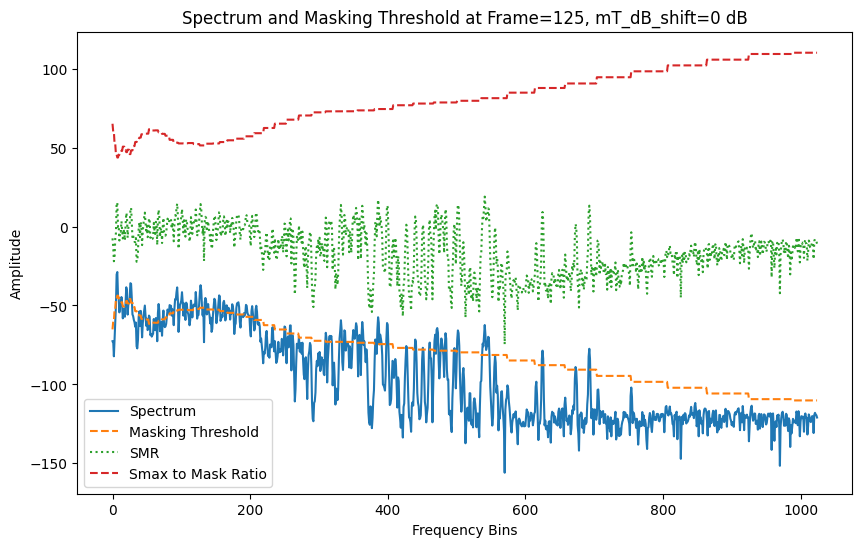

In [37]:
mT_frame_bad, ys_frame_bad = plot_bark_mt_bits(ys_bad)

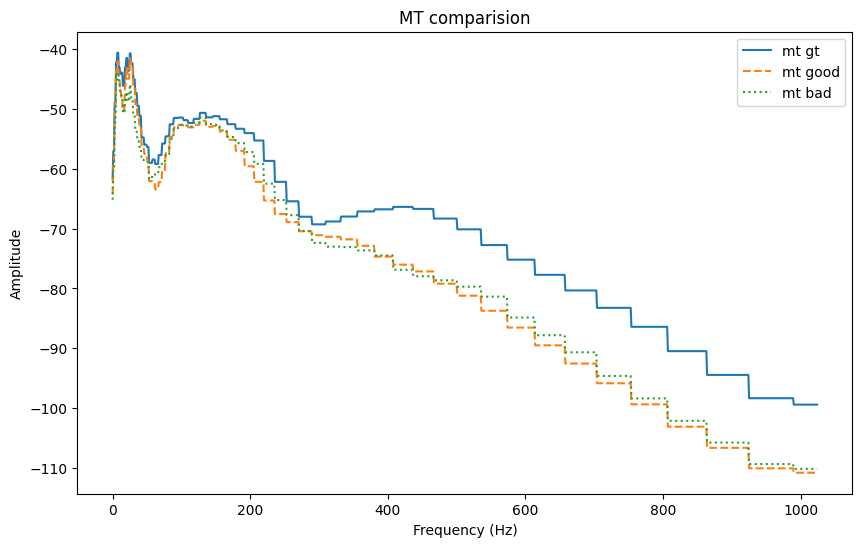

In [38]:
plt.figure(figsize=(10, 6))
freqs = np.linspace(0, 1024, 1025)  # 1025 frequency bins
plt.plot(freqs, mT_frame_gt, label="mt gt")
plt.plot(freqs, mT_frame_good, label="mt good", linestyle="--")
plt.plot(freqs, mT_frame_bad, label="mt bad", linestyle="dotted")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title(
    f"MT comparision"
)
plt.legend()
plt.show()

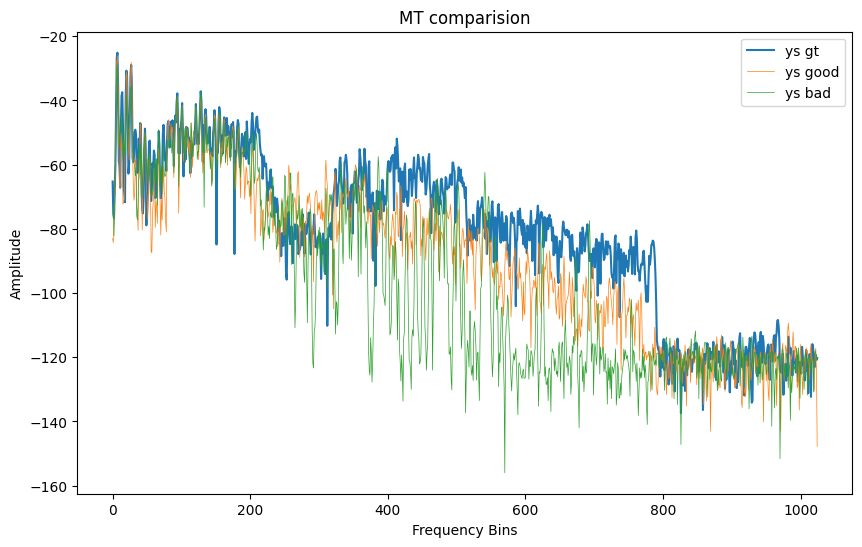

In [39]:
plt.figure(figsize=(10, 6))
freqs = np.linspace(0, 1024, 1025)  # 1025 frequency bins
plt.plot(freqs, ys_frame_gt, label="ys gt")
plt.plot(freqs, ys_frame_good, label="ys good", linewidth=0.5)
plt.plot(freqs, ys_frame_bad, label="ys bad", linewidth=0.5)

plt.xlabel("Frequency Bins")
plt.ylabel("Amplitude")
plt.title(
    f"MT comparision"
)
plt.legend()
plt.show()

## MSE loss in time domain

In [40]:
import torch.nn.functional as F
mse_loss_good_gt = F.mse_loss(ys_gt, ys_good)
print("mse_loss_good_gt", mse_loss_good_gt.item())  # loss should be small
mse_loss_bad_gt = F.mse_loss(ys_gt, ys_bad)
print("mse_loss_bad_gt", mse_loss_bad_gt.item())  # loss should be large
print(
    "mse loss: good/bad ratio, small is better",
    mse_loss_good_gt.item() / mse_loss_bad_gt.item(),
)

mse_loss_good_gt 2.064077989416546e-06
mse_loss_bad_gt 3.443291916482849e-06
mse loss: good/bad ratio, small is better 0.5994490271173113


## Psycho-acoustic loss with masking threshold weighting, without LTQ, without mt shift

In [41]:
# single file example with weighting
ploss_good = psycho_acoustic_loss(
    ys_gt,
    ys_good,
    fs=sample_rate,
    N=N,
    nfilts=nfilts,
    use_weighting=True,
    use_LTQ=False,
    mT_shift=0.00,
)
print("weighted loss: good, gt", ploss_good.item())

ploss_bad = psycho_acoustic_loss(
    ys_gt,
    ys_bad,
    fs=sample_rate,
    N=N,
    nfilts=nfilts,
    use_weighting=True,
    use_LTQ=False,
    mT_shift=0.00,
)
print("weighted loss: bad, gt", ploss_bad.item())
print(
    "weighted loss: good/bad ratio, small is better",
    ploss_good.item() / ploss_bad.item(),
)
print("compare psyloss with mse, psyloss ratio should be smaller")

weighted loss: good, gt 6.580975764336472e-10
weighted loss: bad, gt 1.0656259208374763e-09
weighted loss: good/bad ratio, small is better 0.6175690395335427
compare psyloss with mse, psyloss ratio should be smaller


## Psycho-acoustic loss with masking threshold diff, without LTQ, without mt shift

In [42]:
# single file example without weighting
ploss_good = psycho_acoustic_loss(
    ys_gt,
    ys_good,
    fs=sample_rate,
    N=N,
    nfilts=nfilts,
    use_weighting=False,
    use_LTQ=False,
)
print("psy loss: good, gt", ploss_good.item())

ploss_bad = psycho_acoustic_loss(
    ys_gt,
    ys_bad,
    fs=sample_rate,
    N=N,
    nfilts=nfilts,
    use_weighting=False,
    use_LTQ=False,
)
print("psy loss: bad, gt", ploss_bad.item())
print(
    "psy loss: good/bad ratio, small is better",
    ploss_good.item() / ploss_bad.item(),
)

psy loss: good, gt 5.8046416597790085e-06
psy loss: bad, gt 7.967514648044016e-06
psy loss: good/bad ratio, small is better 0.7285385614200305


## Psycho-acoustic loss with masking threshold weighting, with LTQ, without mt shift

In [43]:
# single file example with weighting and LTQ
ploss_good = psycho_acoustic_loss(
    ys_gt,
    ys_good,
    fs=sample_rate,
    N=N,
    nfilts=nfilts,
    use_weighting=True,
    use_LTQ=True,
)
print("weighted loss + LTQ: good, gt", ploss_good.item())

ploss_bad = psycho_acoustic_loss(
    ys_gt,
    ys_bad,
    fs=sample_rate,
    N=N,
    nfilts=nfilts,
    use_weighting=True,
    use_LTQ=True,
)
print("weighted loss + LTQ: bad, gt", ploss_bad.item())
print(
    "weighted loss + LTQ: good/bad ratio, small is better",
    ploss_good.item() / ploss_bad.item(),
)

weighted loss + LTQ: good, gt 8.701985243497745e-10
weighted loss + LTQ: bad, gt 1.4265140180214075e-09
weighted loss + LTQ: good/bad ratio, small is better 0.6100175065624315


## Psycho-acoustic loss with masking threshold diff, with LTQ, without mt shift

In [44]:
# single file example without weighting and with LTQ
ploss_good = psycho_acoustic_loss(
    ys_gt,
    ys_good,
    fs=sample_rate,
    N=N,
    nfilts=nfilts,
    use_weighting=False,
    use_LTQ=True,
)
print("psy loss + LTQ: good, gt", ploss_good.item())

ploss_bad = psycho_acoustic_loss(
    ys_gt,
    ys_bad,
    fs=sample_rate,
    N=N,
    nfilts=nfilts,
    use_weighting=False,
    use_LTQ=True,
)
print("psy loss + LTQ: bad, gt", ploss_bad.item())
print(
    "psy loss + LTQ: good/bad ratio, small is better",
    ploss_good.item() / ploss_bad.item(),
)

psy loss + LTQ: good, gt 3.9411670513800345e-06
psy loss + LTQ: bad, gt 5.276992396829883e-06
psy loss + LTQ: good/bad ratio, small is better 0.7468585806088452


## Psycho-acoustic loss with masking threshold weighting, with LTQ, with mt shift

In [45]:
# single file example with weighting and with LTQ, with mT_dB_shift

mT_dB_shift = 200

ploss_good = psycho_acoustic_loss(
    ys_gt,
    ys_good,
    fs=sample_rate,
    N=N,
    nfilts=nfilts,
    use_weighting=True,
    use_LTQ=True,
    mT_shift=mT_dB_shift,
)
print(f"weighted loss + LTQ + shift {mT_dB_shift}: good, gt", ploss_good.item())

ploss_bad = psycho_acoustic_loss(
    ys_gt,
    ys_bad,
    fs=sample_rate,
    N=N,
    nfilts=nfilts,
    use_weighting=True,
    use_LTQ=True,
    mT_shift=mT_dB_shift,
)
print(f"weighted loss + LTQ + shift {mT_dB_shift}: bad, gt", ploss_bad.item())
print(
    "weighted loss + LTQ: good/bad ratio, small is better",
    ploss_good.item() / ploss_bad.item(),
)

weighted loss + LTQ + shift 200: good, gt 9.598190991999545e-11
weighted loss + LTQ + shift 200: bad, gt 1.5751908111205637e-10
weighted loss + LTQ: good/bad ratio, small is better 0.6093351309719459
